# Лабораторная работа №2
**Цель работы:** практическое применение дискретного преобразования Фурье c использованием библиотек Python для анализа речевых сигналов.


**Задачи:** 
- Используя ДПФ построить траекторию основного тона (F0) на записи своего голоса.
- Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на записи своего голоса
- Построить сонограмму по записи своего голоса.

## Ход работы

### 1. Подключение основных библиотек и считывание записи

In [142]:
import numpy as np
import scipy.signal as signal 
import matplotlib.pyplot as plt
import IPython
from scipy.io import wavfile 
from more_itertools import windowed
%matplotlib inline 
plt.rcParams['figure.figsize'] = [20, 10]

Рисуем график сигнала

16000
8.7775625


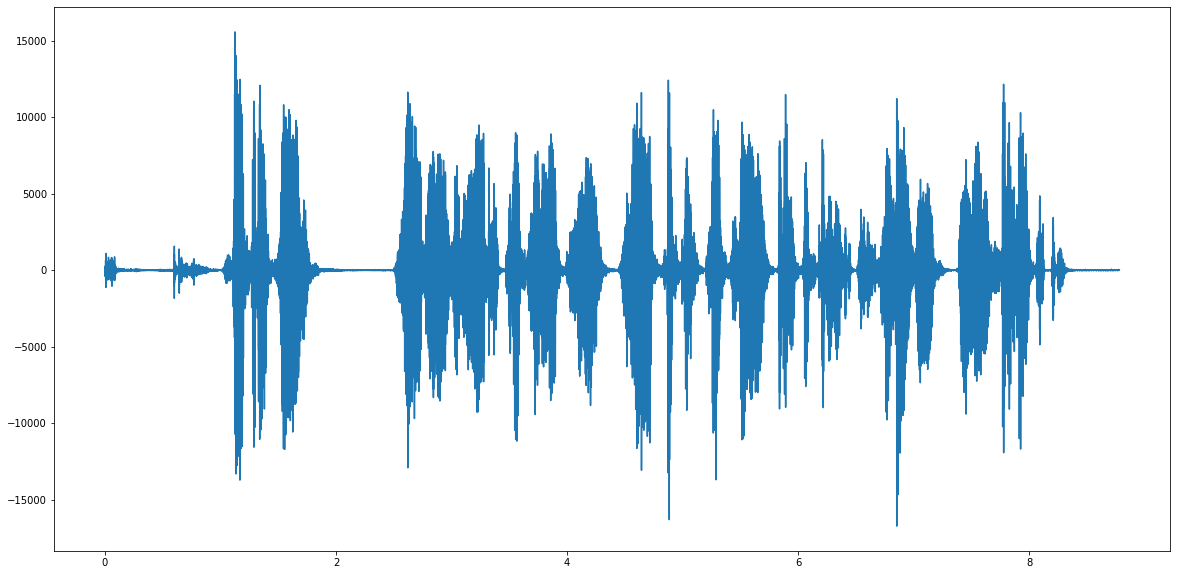

In [143]:
samplerate, data = wavfile.read('./record.wav')
length = data.shape[0] / samplerate
time = np.linspace(0., length, data.shape[0])
plt.plot(time, data)
print(samplerate,length,sep='\n')

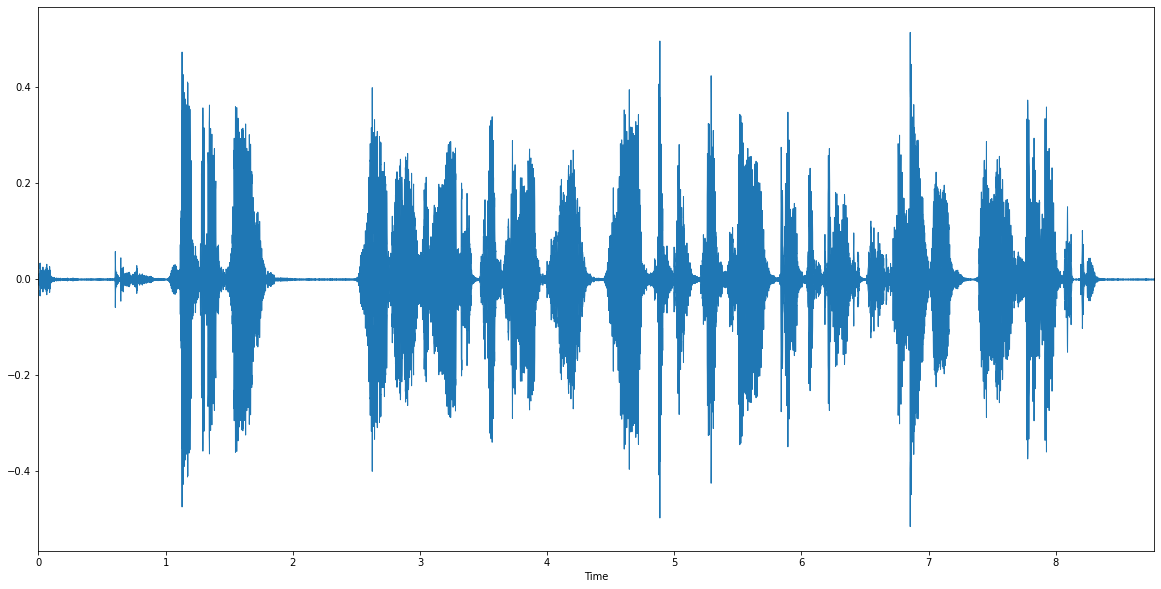

In [144]:
import matplotlib.pyplot as plt
import librosa.display
lib_x , lib_sr = librosa.load('./record.wav')
librosa.display.waveplot(lib_x, sr=lib_sr)

Можем прослушать запись

In [145]:
IPython.display.Audio(data, rate=samplerate)

### 2. Используя ДПФ построить траекторию основного тона (F0) на записи своего голоса.

Устанавливаем начальные параметры

In [146]:
N=1024 #размерность фурье
S=samplerate/N #спектральное резрешение 
print(S)
f_d= [80,200]#диапазон основного тона
n_d=[int(f_d[0]/S),int(f_d[1]/S)]
print(f_d,n_d)

15.625
[80, 200] [5, 12]


Разбиваем сигнал на множество вложенных отрезков длиной N и умножаем каждый отрезок на окно hanning.

In [147]:
intervals = list( windowed(data, n=N, step=int(N*0.10)) )
intervals[-1]=( i for i in intervals[-1] if i )
intervals=[list(i) for i in intervals]
intervals=[i*np.hanning(len(i)) for i in intervals]

Рассмотрим один из отрезков после умножение на окно hanning.

1024
1024


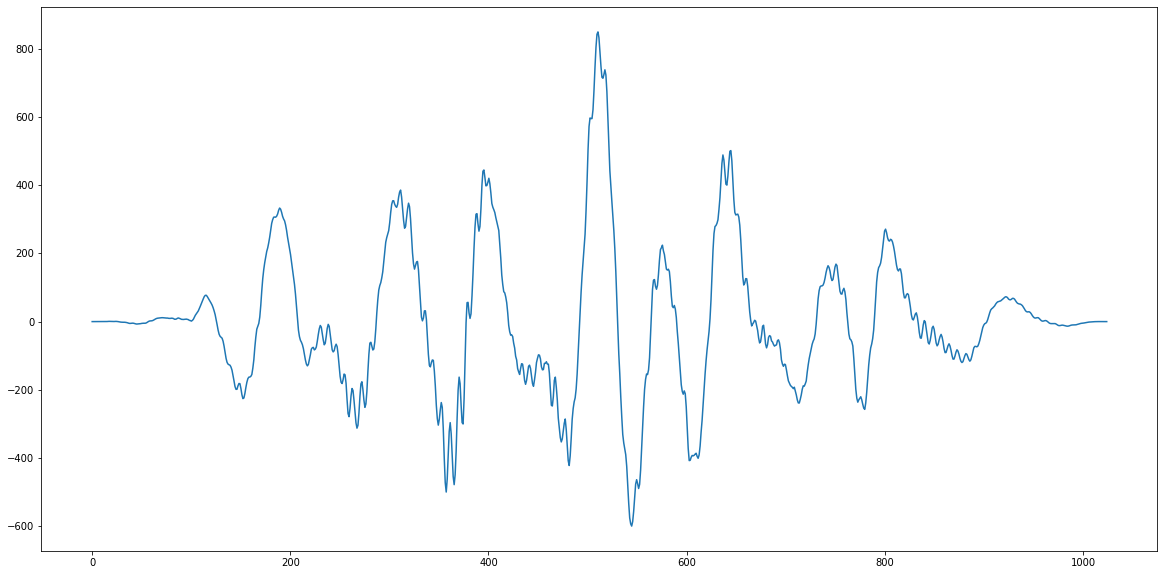

In [148]:
data_after_hanning = [i for i in intervals[0]]
points = np.linspace(0. ,N , len(data_after_hanning))
print(len(data_after_hanning))
print(len(points))
plt.plot(points, data_after_hanning)

Вычисляем ДПФ

In [149]:
intervals=np.delete(intervals,-1)
print(len(intervals),len(intervals[-1]))

1367 1024


/home/vikdema/my_project_env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [150]:
def DFT_slow(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

def FFT(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if N <= 32:
        return DFT_slow(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:int(N / 2)] * X_odd,
                               X_even + factor[int(N / 2):] * X_odd])
df=[]
for m in range(0,int(len(intervals))):
    if m%100==0:
        print(m)
    df.append(FFT(intervals[m]))
        

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [151]:
df=np.transpose(df)

Через библиотеку librosa

In [152]:
lib_X = librosa.stft(lib_x,n_fft=N)


Построим амплитудный спектр для первого отрезка

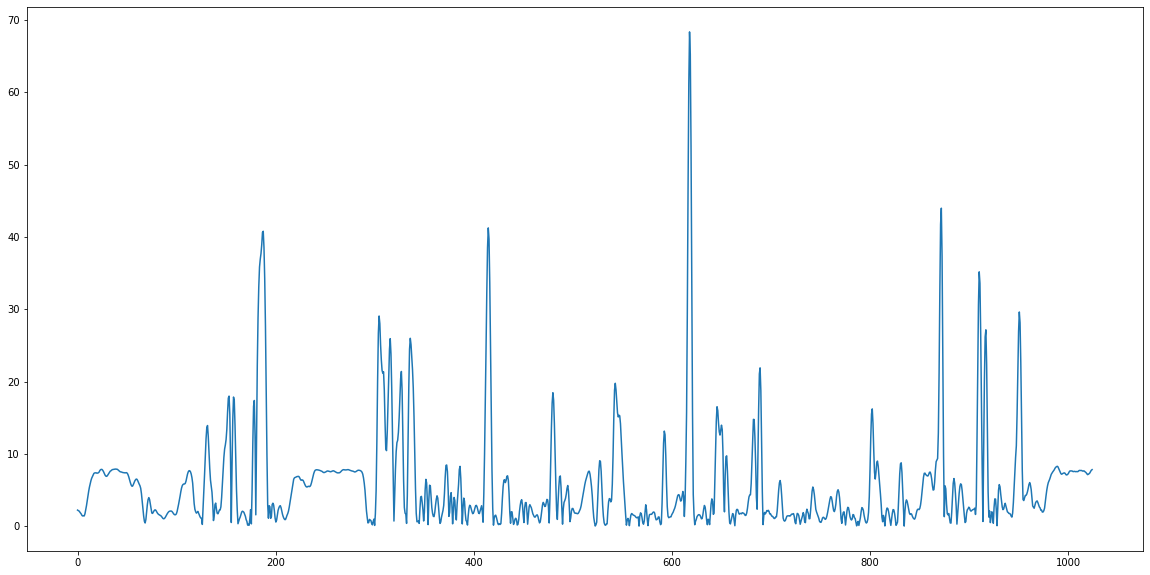

In [153]:
amplitude_spectrum = [np.sqrt(i.real**2+i.imag**2)/N for j in df for i in j ]
points = np.linspace(0. ,N , int(len(df[0])))
plt.plot(points, amplitude_spectrum[:int(len(df[0]))]) 

Теперь для librosa

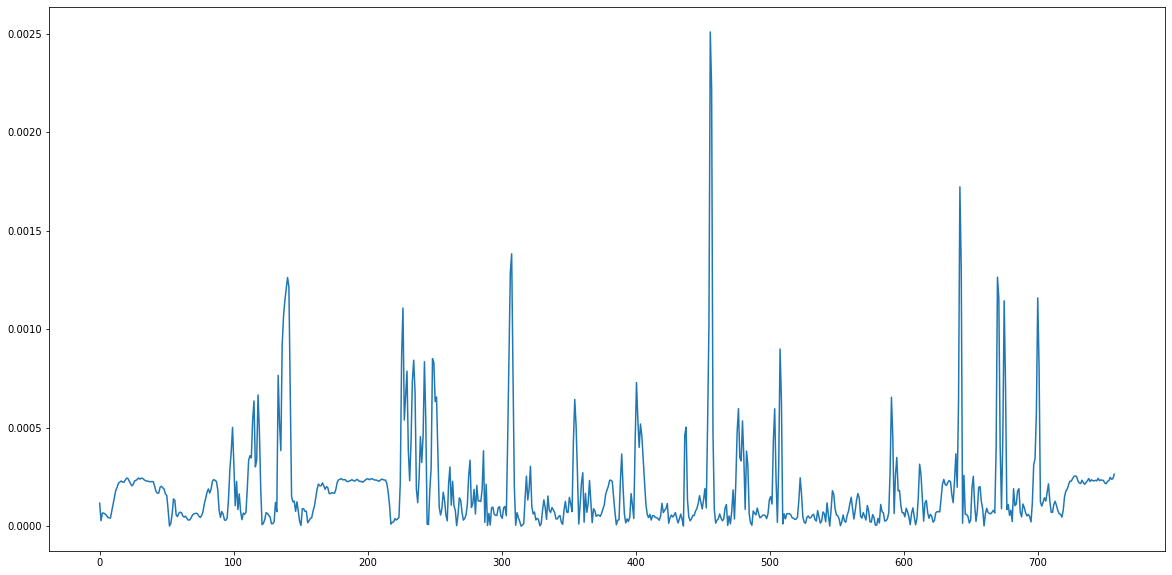

In [154]:
amplitude_spectrum_lib = [np.sqrt(i.real**2+i.imag**2)/N for j in lib_X for i in j ]
points = np.linspace(0. ,int(len(lib_X[0])) , int(len(lib_X[0])))
plt.plot(points, amplitude_spectrum_lib[:int(len(lib_X[0]))]) 

Можем заметить одинаковый результат, теперь построим полный амплитудный спектр для своей и библиотечной реализации.

1399808


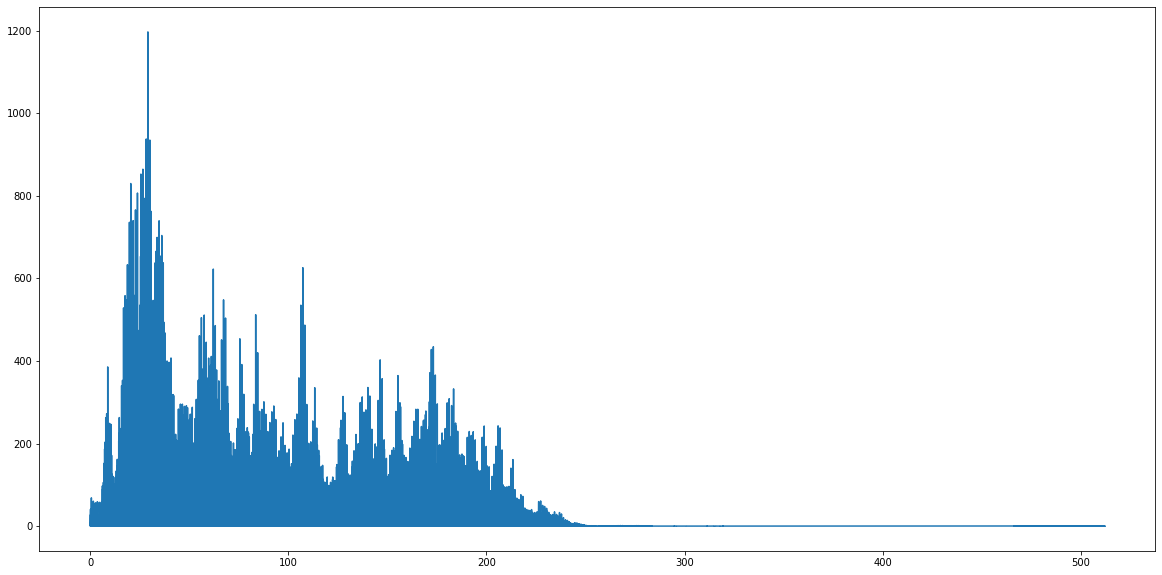

In [155]:
points = np.linspace(0. ,N/2 , int(len(amplitude_spectrum)/2))
print(len(amplitude_spectrum))
plt.plot(points, amplitude_spectrum[:int(len(amplitude_spectrum)/2)]) 

388341


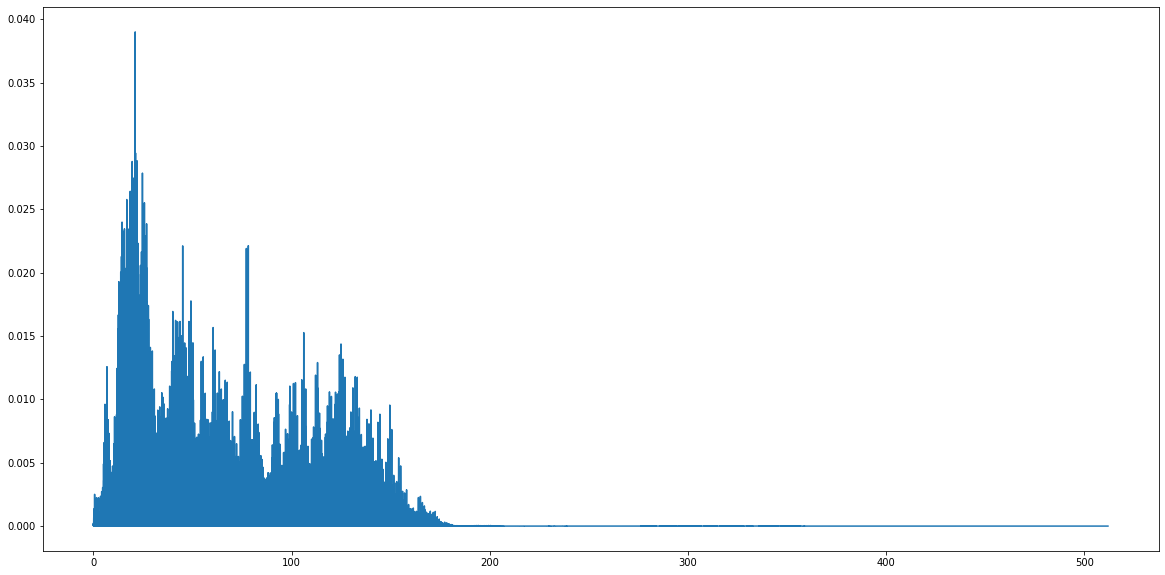

In [156]:
points = np.linspace(0. ,N/2 , len(amplitude_spectrum_lib))
print(len(amplitude_spectrum_lib))
plt.plot(points, amplitude_spectrum_lib) 

Построить траекторию основного тона(F0)

2734
1367


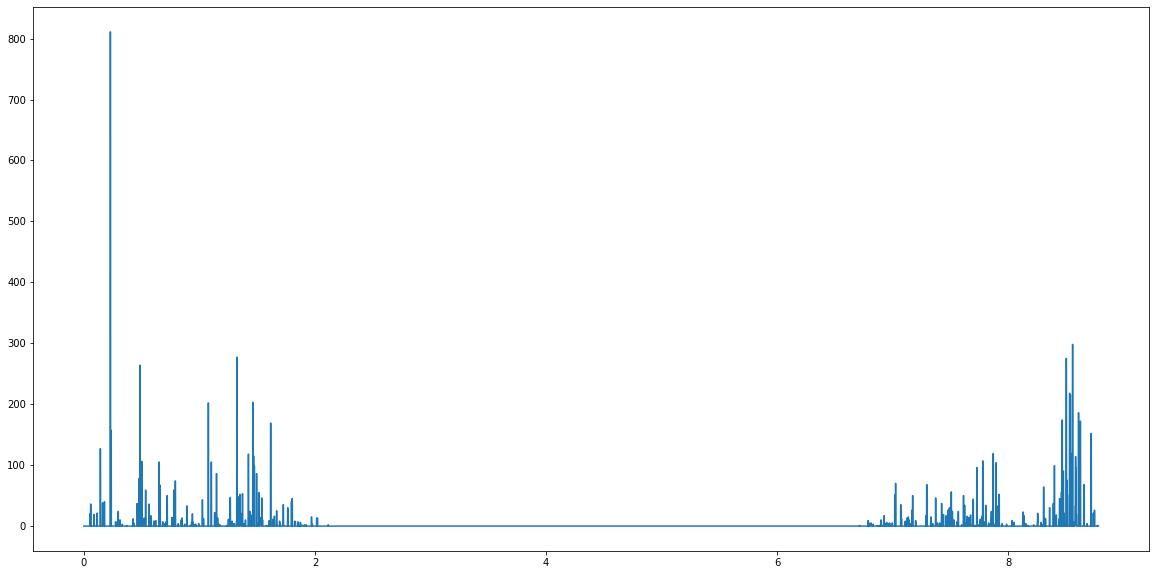

In [157]:
from more_itertools import sliced
chunk = list(sliced(amplitude_spectrum, int(N/2)))
print(len(chunk))
print(len(intervals))

def check_f0(x):
    max_=max(x[n_d[0]:n_d[1]])
    if max_*0.5 > sum(x[n_d[0]:n_d[1]])/len(x[n_d[0]:n_d[1]]):
        return int(max_)
    return 0
for i in chunk:
    temp = check_f0(i)
    if temp==0:
        for j in range(len(i)):
            i[j]=0
    else:
        for j in range(len(i)):
            i[j]=temp

def listmerge1(lstlst):
    all=[]
    for lst in lstlst:
        for el in lst:
            all.append(el)
    return all
res=listmerge1(chunk)
points = np.linspace(0., length, len(res))
plt.plot(points, res) 

### 2.Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на записи своего голоса

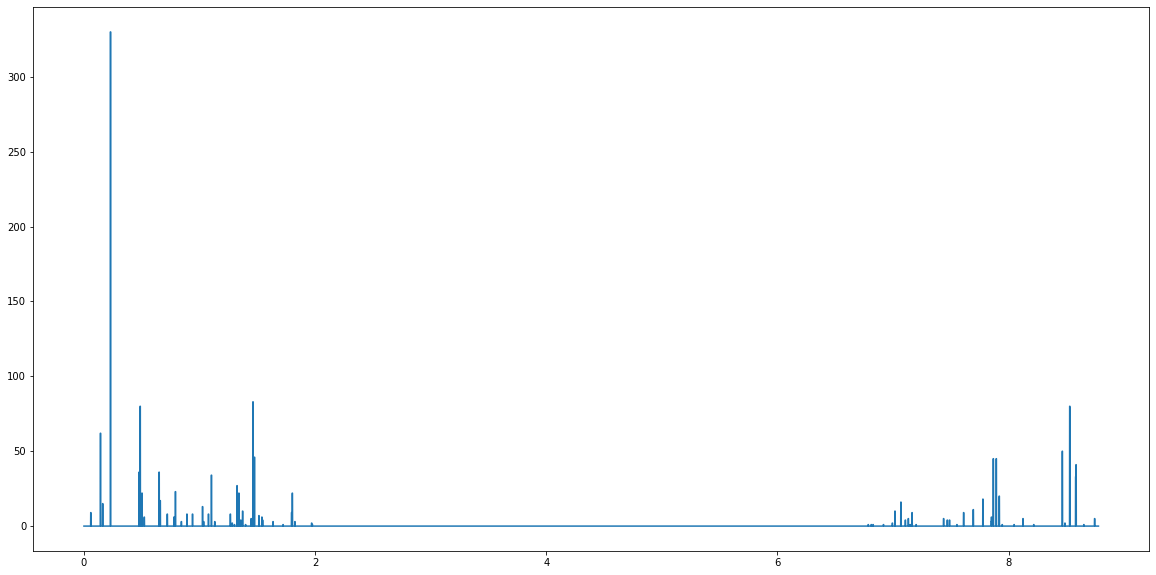

In [158]:
chunk = list(sliced(amplitude_spectrum, int(N/2)))

def check_f1(x):
    max_=max(x[n_d[0]:n_d[1]])
    if max_*0.5 > sum(x[n_d[0]:n_d[1]])/len(x[n_d[0]:n_d[1]]):
        ind = x[n_d[0]:n_d[1]].index(max_)
        max_1=max([x[ind*2-n_d[1]-n_d[0]],x[ind*2+n_d[1]-n_d[0]]])
        if max_*0.5>max_1:
            return int(max_1)
        else:
            return 0
    return 0

for i in chunk:
    temp = check_f1(i)
    if temp==0:
        for j in range(len(i)):
            i[j]=0
    else:
        for j in range(len(i)):
            i[j]=temp

def listmerge1(lstlst):
    all=[]
    for lst in lstlst:
        for el in lst:
            all.append(el)
    return all

res=listmerge1(chunk)
points = np.linspace(0., length, len(res))
plt.plot(points, res) 

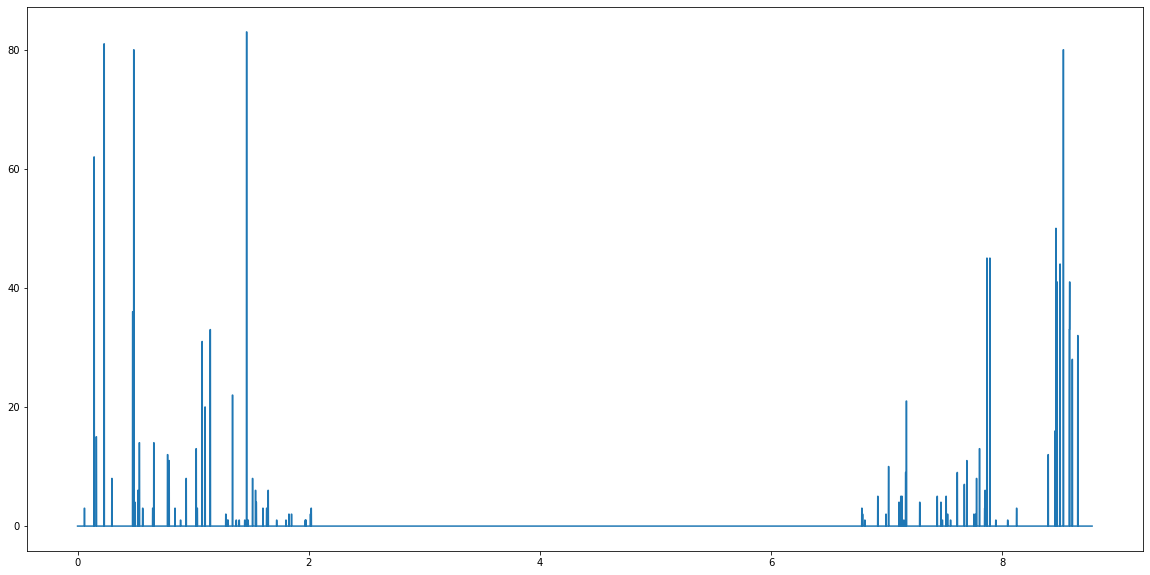

In [159]:
chunk = list(sliced(amplitude_spectrum, int(N/2)))

def check_f2(x):
    max_=max(x[n_d[0]:n_d[1]])
    if max_*0.5 > sum(x[n_d[0]:n_d[1]])/len(x[n_d[0]:n_d[1]]):
        ind = x[n_d[0]:n_d[1]].index(max_)
        max_2=max([x[ind*3-n_d[1]-n_d[0]],x[ind*3+n_d[1]-n_d[0]]])
        if max_*0.5>max_2:
            return int(max_2)
        else:
            return 0
    return 0

for i in chunk:
    temp = check_f2(i)
    if temp==0:
        for j in range(len(i)):
            i[j]=0
    else:
        for j in range(len(i)):
            i[j]=temp

def listmerge1(lstlst):
    all=[]
    for lst in lstlst:
        for el in lst:
            all.append(el)
    return all

res=listmerge1(chunk)
points = np.linspace(0., length, len(res))
plt.plot(points, res) 

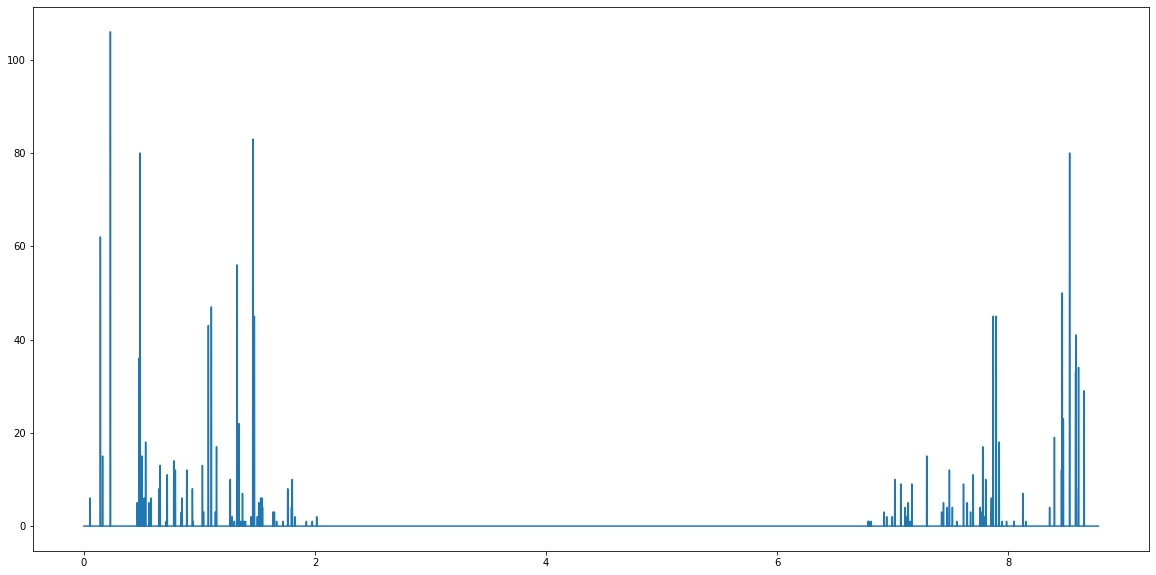

In [160]:
chunk = list(sliced(amplitude_spectrum, int(N/2)))

def check_f2(x):
    max_=max(x[n_d[0]:n_d[1]])
    if max_*0.5 > sum(x[n_d[0]:n_d[1]])/len(x[n_d[0]:n_d[1]]):
        ind = x[n_d[0]:n_d[1]].index(max_)
        max_3=max([x[ind*4-n_d[1]-n_d[0]],x[ind*4+n_d[1]-n_d[0]]])
        if max_*0.5>max_3:
            return int(max_3)
        else:
            return 0
    return 0

for i in chunk:
    temp = check_f2(i)
    if temp==0:
        for j in range(len(i)):
            i[j]=0
    else:
        for j in range(len(i)):
            i[j]=temp

def listmerge1(lstlst):
    all=[]
    for lst in lstlst:
        for el in lst:
            all.append(el)
    return all

res=listmerge1(chunk)
points = np.linspace(0., length, len(res))
plt.plot(points, res) 

### 3.Построить сонограмму по записи своего голоса.

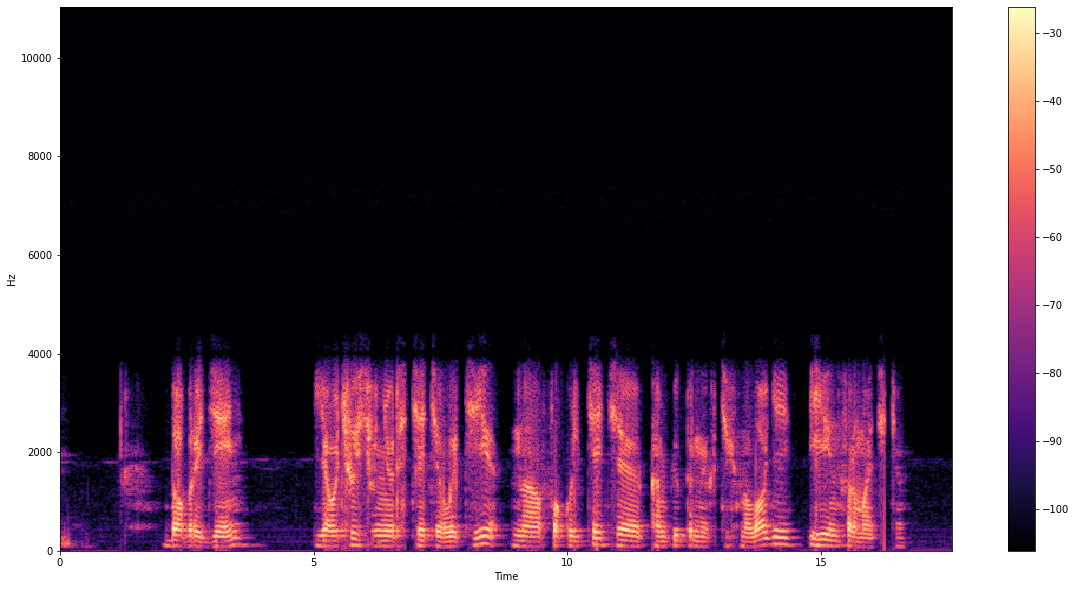

In [161]:
S_db = librosa.amplitude_to_db(np.abs(lib_X) , ref=A_max)
plt.figure()
librosa.display.specshow(S_db, sr=lib_sr,x_axis='time', y_axis='hz')
plt.colorbar()

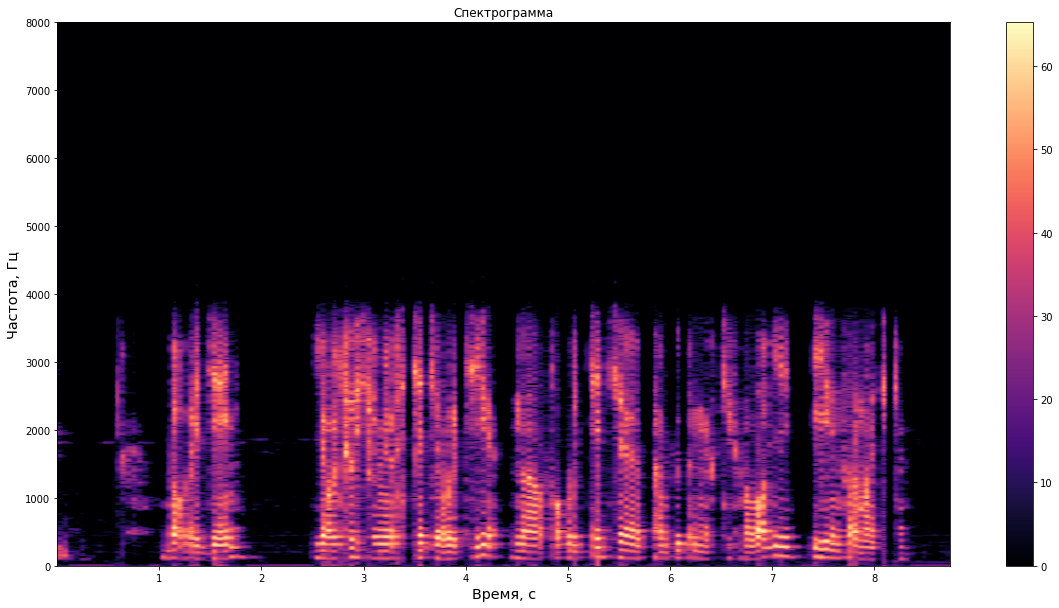

In [163]:
import matplotlib
plt.xlabel('Время, c', fontsize='x-large')
plt.ylabel('Частота, Гц', fontsize='x-large')
plt.title('Спектрограмма')

plt.specgram(data,NFFT=N, pad_to=N, mode='magnitude', Fs=samplerate, cmap=cmap)
plt.clim(vmin=0)
plt.colorbar()
plt.show()